In [1]:
import pandas as pd
import matplotlib.pyplot as plt


plt.rcParams["figure.figsize"] = (15,8)
plt.rcParams["axes.labelsize"] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['grid.linewidth'] = .5
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['legend.fontsize'] = 15

In [2]:
def calculate_ema(_series: pd.Series, n: int):
    """
        Расчет EMA
    Тоже самое что и _series.ewm(span=n)
    """
    k = 2/(n+1)
    ema_values = [_series[:n].mean()]
    for i in range(1, _series.size):
        ema_values.append(_series[i]*k+ema_values[i-1]*(1-k))
    return pd.Series(data=ema_values, index=_series.index)


def calculate_sma(_series: pd.Series, n: int):
    """
        Расчет SMA
    Тоже самое что и _series.rolling(n).mean()
    """
    sma_values = []
    for i in range(n-1, _series.size):
        sma_values.append(sum(_series[i+1-n:i+1])/n)
    return pd.Series(data=sma_values, index=_series.index[n-1:])

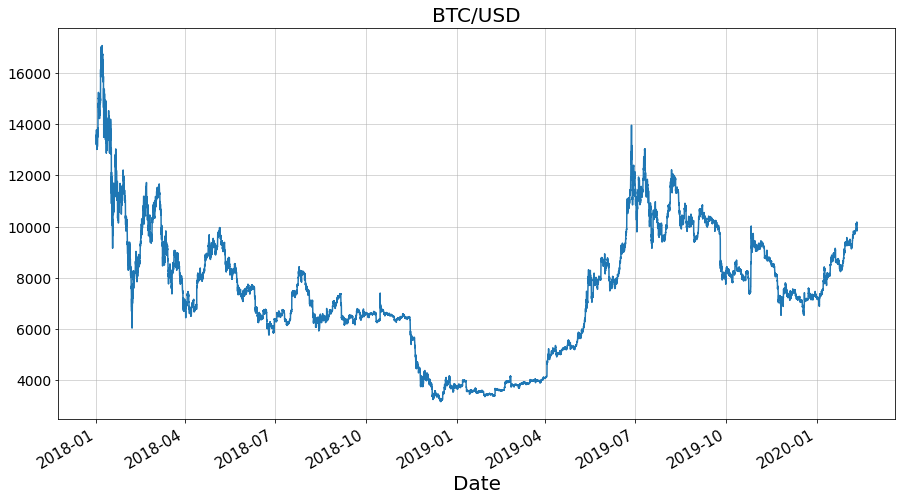

In [3]:
series = pd.read_csv('data/btc_1h.csv', index_col='date', parse_dates=True)['close']['2018':]
series = pd.to_numeric(series, downcast='float')
series.index.name = 'Date'

series.plot();
plt.xticks(rotation=30)
plt.title('BTC/USD')
plt.show()

In [4]:
short_ema = series.ewm(span=12).mean()
long_ema = series.ewm(span=26).mean()
macd = long_ema - short_ema
signal = macd.rolling(9).mean()
macd_hist = macd - signal

In [5]:
tmp_cross = signal - macd_hist
cross = pd.DataFrame({
    'now': tmp_cross, 
    'previous': tmp_cross.shift(1),
    'macd_hist': macd_hist,
    'signal': signal
}).dropna()

In [6]:
result = pd.DataFrame(columns=['act', 'price'])
for index, (now, previous, mh, sig) in cross.iterrows():
    if now < 0 < previous and mh < 0 and sig < 0:
        result.loc[index] = ['sell', series[index]]
    elif previous < 0 < now and mh > 0 and sig > 0:
        result.loc[index] = ['buy', series[index]]

In [7]:
result

,act,price
2018-01-01 09:00:00,sell,13616.990234
2018-01-01 18:00:00,buy,13135.000000
2018-01-02 04:00:00,sell,13127.309570
2018-01-02 17:00:00,sell,13780.000000
2018-01-02 22:00:00,sell,14799.959961
...,...,...
2020-02-03 01:00:00,sell,9430.730469
2020-02-03 22:00:00,buy,9353.610352
2020-02-06 00:00:00,sell,9563.000000
2020-02-08 21:00:00,sell,9793.509766
